In [33]:
import numpy as np
import matplotlib.pyplot as plt

font = {'family' : 'normal',
        'weight' : 'bold',
        'size': 16}
plt.rc('font', **font)

from Huffman_functions import *
from Masking_functions import *

In [34]:
def functions_from_HW3(fb, N):
    decod_dicts = []
    steps = []
    lens = []
    coded_strings = bitarray()
    data8bits = []
    for i in range(N):
        step_size = (float(np.max(fb.y2[i, :])) - float(np.min(fb.y2[i, :]))) / 2**8
        data8bit = (fb.y2[i, :] / step_size).astype(np.int8)
        data8bits.append(data8bit)
        huffman = Huffman(data8bit)
        decod_dict, coded_string = huffman.encode()
        decod_dicts.append(decod_dict)
        lens.append(len(coded_string))
        coded_strings.extend(coded_string)
        steps.append(step_size)
    return steps, decod_dicts, coded_strings, data8bits, lens

def map2hz_mat_new(W, nfft):
    nfreqs = int(nfft/2)
    W_inv = np.dot(np.diag((1.0/(np.sum(W,1)+0.01))**0.5), W[:,0:nfreqs + 1]).T
    return W_inv

In [35]:
# mdct -> masking threshold -> quantization -> coding
def SNR(x, x_hat, N):
    #p_x = np.sum(np.abs(x[:-2*N])**2)
    p_x = np.var(x[:-2*N])
    #p_x_hat = np.sum(np.abs(x[:-2*N] - x_hat[2*N:])**2)
    p_x_hat = np.var(x[:-2*N] - x_hat[2*N:])
    ratio_lin = (p_x / p_x_hat)
    return ratio_lin

def test(x0, N, q, blocks, alpha):
    nfft = 2*(N-1)
    fb = Filter_banks(x0, N)
    # choosing window function for MDCT
    #fb.h_n = np.sin(np.pi/(2*N) * (np.arange(int(2*N))+0.5)) * np.sqrt(2/N)
    fb.analysis()

    W, nfilts, max_brk = map2brk_mat(fs, nfft)
    Zxx_brk = map2brk(fb.y2, W, nfft)
    sf_mat = SF_mat(max_brk, nfilts, alpha)
    W_inv = map2hz_mat_new(W, nfft)

    bit_steps_mat = np.zeros((fb.y2.shape[0], fb.y2.shape[1]//blocks), dtype=np.float32)
    new_steps = np.zeros((fb.y2.shape[0], fb.y2.shape[1]//blocks), np.float32)
    x2 = np.zeros_like(fb.y2)

    for i in range(fb.y2.shape[1]//blocks):  # 160
        x1 = Zxx_brk[i*blocks, :]
        mt_bark2 = MTQ_bark(x1, sf_mat, max_brk, nfilts, alpha) * q
        mt2 = map2hz(mt_bark2, W_inv, nfft)

        steps = mt2.copy()
        bit_steps_mat[:, i] = steps

    for i in range(N):
        num_steps = (np.max(fb.y2[i, :]) - np.min(fb.y2[i, :])) / bit_steps_mat[i, :]
        num_steps[num_steps > 10**6] = 10**6
        num_steps_new = 2 ** np.ceil(np.log2(num_steps))
        new_steps[i, :] = (np.max(fb.y2[i, :]) - np.min(fb.y2[i, :])) / num_steps_new #/ (2**bit_steps_mat[i, :])
        for j in range(fb.y2.shape[1]//blocks):
            x2[i, blocks*j:blocks*j+blocks] = fb.y2[i, blocks*j:blocks*j+blocks] / new_steps[i, j]

    x2 = x2.astype(np.int32)
    
    # hw4
    pickle.dump([new_steps, x2], open(encoded_hw4, "wb"), 1) 
    x_hat = np.zeros_like(x2)
    for i in range(x2.shape[1]):
        x_hat[:, i] = x2[:, i] * new_steps[:, i//blocks]
    x_hw4 = fb.synthesis(x_hat)

    decod_dicts = []
    steps = []
    lens = []
    coded_strings = bitarray()
    data8bits = []

    for i in range(N):
        huffman = Huffman(x2[i, :])
        decod_dict, coded_string = huffman.encode()
        decod_dicts.append(decod_dict)
        lens.append(len(coded_string))
        coded_strings.extend(coded_string)

    # hw6
    pickle.dump([new_steps, decod_dicts, coded_strings, lens], open(encoded_hw6, "wb"), 1)
    
    # decode 2
    [new_steps_dec, decod_dicts_dec, coded_strings_dec, lens_dec] = pickle.load(open(encoded_hw6, "rb"))

    r = 0
    y2_dec1 = np.zeros_like(x2)
    y2_dec2 = np.zeros_like(x2)
    for i in range(N):
        try:
            y2_dec1[i, :] = decode_h(decod_dicts_dec[i], coded_strings_dec[r:r+lens[i]])
        except:
            pass
        y2_dec2[i, :] = y2_dec1[i, :] * np.repeat(new_steps_dec[i], blocks)
        r += lens[i]
    x_hat2 = fb.synthesis(y2_dec2)
    
    wavfile.write("restored.wav", rate=fs, data=x_hat2.astype(np.int16))
    
    # hw3
    #steps, decod_dicts, coded_strings, data8bits, lens
    tmp1 = functions_from_HW3(fb, N)
    pickle.dump([*tmp1], open(encoded_hw3, "wb"), 1)
    [new_steps_dec, decod_dicts_dec, coded_strings_dec, lens_dec] = pickle.load(open(encoded_hw6, "rb"))

    x_hw3 = fb.synthesis(tmp1[3])
    
    
    wavfile.write("restored.wav", rate=fs, data=x_hat2.astype(np.int16))
    mt_new = np.zeros((N))
    for i in range(x2.shape[1]):
        x1_i = Zxx_brk[i, :]
        mt_bark2_i = MTQ_bark(x1_i, sf_mat, max_brk, nfilts, alpha)
        mt2_i = map2hz(mt_bark2_i, W_inv, nfft)
        mt_new += mt2_i
    mt_new /= x2.shape[1]

    fig = plt.figure(figsize = (10, 6))
    ax = fig.add_subplot()
    ax.semilogy(mt_new)
    ax.semilogy(new_steps.mean(axis=1))
    plt.legend(["Masking threshold", "Quantization noise"])
    plt.xlabel("MDCT bands")
    plt.grid()

    fig2 = plt.figure(figsize = (10, 6))
    ax2 = fig2.add_subplot()
    ax2.plot(x0[:-2*N])
    ax2.plot(x_hat2[2*N:])
    plt.legend(["Original", "Reconstructed"])
    plt.xlabel("Samples, N")
    plt.grid()

    print("HW5 + HW6 size:", os.path.getsize(encoded_hw6) / 1024, ", SNR in dB:", 10*np.log10(SNR(x0, x_hat2, N)))
    print("HW4 size", os.path.getsize(encoded_hw4) / 1024, ", SNR in dB:", 10*np.log10(SNR(x0, x_hw4, N)))
    print("HW3 size", os.path.getsize(encoded_hw3) / 1024, ", SNR in dB:", 10*np.log10(SNR(x0, x_hw3, N)))
    print("Original size:", T * 16 / 1024)


In [36]:
from scipy.io import wavfile

castanets = "castanets_16.wav"
audiofile = "rockyou_16.wav"
speech= "speech_16.wav"

encoded_hw6 = "encoded_hw6.bin"
encoded_hw3 = "encoded_hw3.bin"
encoded_hw4 = "encoded_hw4.bin"

In [37]:
# Duration of the signal
start = 0
T = 102_400*3 # in samples

HW5 + HW6 size: 280.9189453125 , SNR in dB: 15.690756470580238
HW4 size 1383.38671875 , SNR in dB: 15.690756470580238
HW3 size 1139.1474609375 , SNR in dB: 0.008282355199552715
Original size: 4800.0


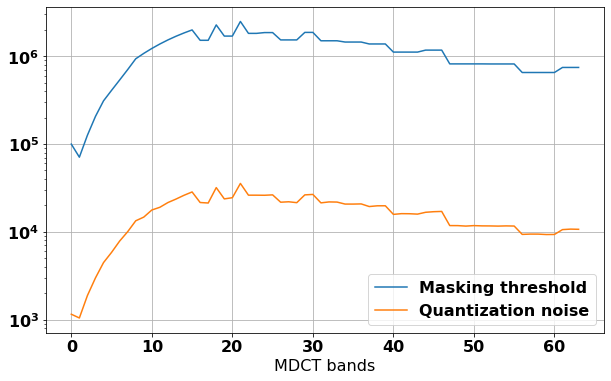

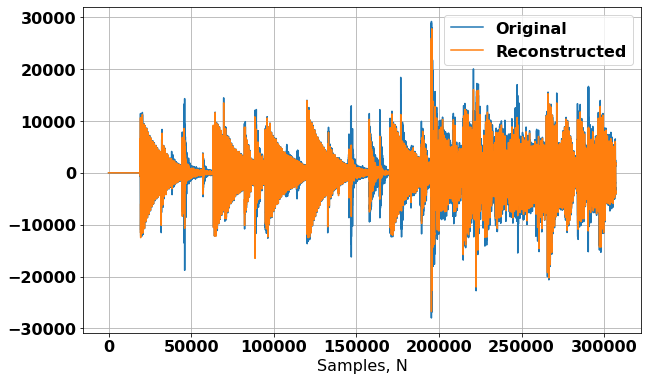

In [38]:
# Test using exponent in spreading function
fs, signal = wavfile.read(audiofile)
x0 = signal[start:start+T]

test(x0, N=64, blocks=10, alpha=0.3, q=0.02)

HW5 + HW6 size: 217.4384765625 , SNR in dB: 1.5569477011314485
HW4 size 1334.1962890625 , SNR in dB: 1.5569477011314485
HW3 size 892.7705078125 , SNR in dB: 0.023030094988573613
Original size: 4800.0


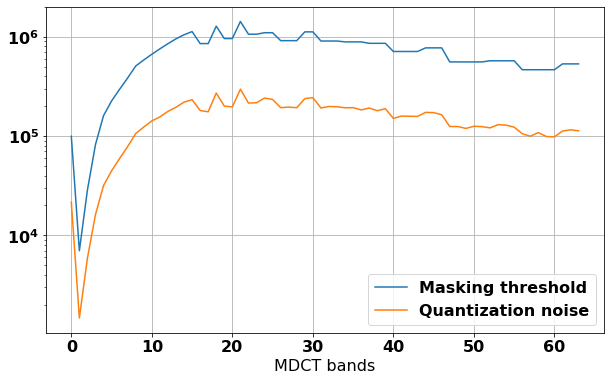

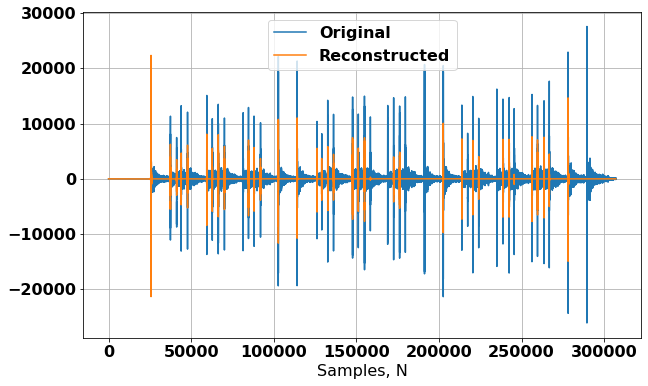

In [39]:
fs, signal = wavfile.read(castanets)
x0 = signal[start:start+T]

test(x0, N=64, blocks=12, alpha=0.3, q=0.3)

HW5 + HW6 size: 130.1171875 , SNR in dB: 0.7619748069034432
HW4 size 1311.9443359375 , SNR in dB: 0.7619748069034432
HW3 size 1339.8486328125 , SNR in dB: 0.017496177723705104
Original size: 4800.0


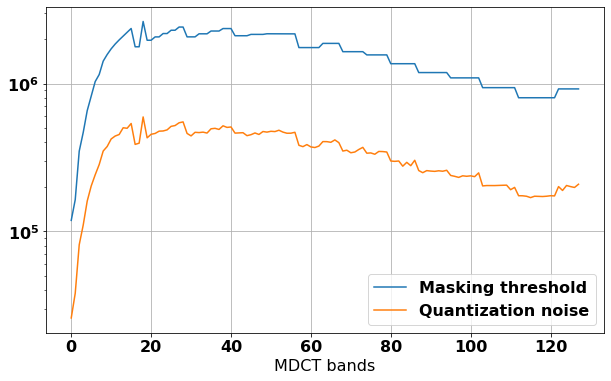

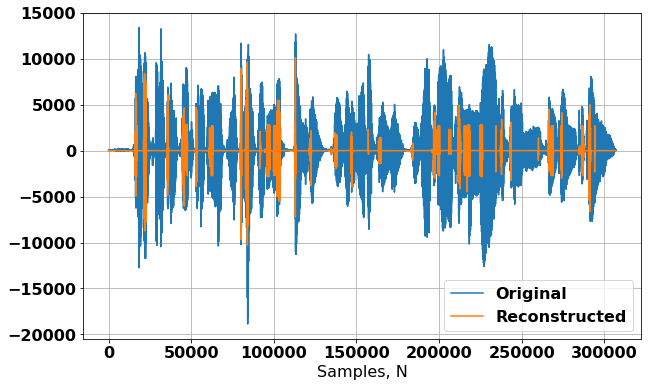

In [40]:
fs, signal = wavfile.read(speech)
x0 = signal[start:start+T]
test(x0, N=128, blocks=15, alpha=0.3, q=0.3)